# **Phishing: jak się nie dać "złapać"**

---

*By Vitalii Morskyi & Julia Makarska*

#TODO: trzeba będzie tu coś ładnego zrobić i ewentualnie poprawnie podać temat projektu bo chyba zapomniałem jak to powinno wyglądać 



## Importowanie danych, pakietów R i modułów
---

In [1]:
library("stringi")
library("stringr")
library("lattice")
library("ggplot2")
library("ggExtra")
library("hrbrthemes")

source("modules/split-url.r")
source("modules/url-ambiguity.r")
source("modules/url-lengths.r")
source("modules/url-special-symbol-count.r")

dfm <- read.csv("data/Webpages_Classification_10k.csv",  row.names = "X") # Mendeley Data : Dataset of Malicious and Benign Webpages
dfp <- read.csv("data/PhishStorm_urlset_96k.csv")                         # Aalto University : PhishStorm - phishing / legitimate URL dataset

Warning message:
"package 'stringr' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'ggExtra' was built under R version 3.6.3"Warning message:
"package 'hrbrthemes' was built under R version 3.6.3"NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.
      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and
      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow


In [2]:
head(dfm, n=1L)

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://www.pureevents.com/,26,94.65.190.24,Greece,com,complete,yes,30,0,"cancer whitenigger niggor phuking stroke trots honkers chink slave blackout bomd vietcong shitfaced swallow kumbubble bitchy negro's sexy crotchrot perv itch splittail dixiedike pubiclice sonofbitch jigg vibrater shhit groe carruth enemy gook poverty slavedriver pissed snowback mofo blackman stupid dink pocho chav sixtyniner rump wanker horniest eatme niggers beastial sweetness kunt moky pee shitlist shitola niggard's buttbang cockfight color drug cumfest rentafuck fatah bicurious wn mothafucking tortur titfucker dickforbrains ikey blacks fuckinnuts slutty titfuck destroy freakfuck assassinate fuckhead japcrap nig wetback canadian geni killing desire flydye bazongas niggah mams shinola sixtynine boobies masterblaster handjob bondage bazooms bollick sniggered nymph slopy uptheass tampon premature beaner nazi sodom hijacker quim smackthemonkey pooperscooper mothafucked ginzo chinky niggling crack pornflick niglet nookie cunilingus kotex shaggin assmuncher meatrack cocaine whiz dumbbitch asswipe knockers palestinian fatass fistfucking bong harder pimped loser assjockey negro butt-fucker flatulence cigs lezzo cocksucking assclown corruption mockey knife fuckme dirty dixiedyke execute piker hotdamn narcotic bountybar wab goddamnit ero mufflikcer sniggers moles backdoor asshat mattressprincess boob pansies unfuckable cohee babe slutwear addicts darkie glazeddonut bohunk porno christian fudgepacker thicklips fucking necro fagging tits retarded molester nigr cockknob puke condom phukked boonie nasty slimeball nooner puntang cocksman schlong penthouse paki geez niggarding slapper homobangers cocksmoker minority asses asskiss slanteye ky angry uk gin fuckina bitcher hymie queef wetb fuckbag mideast butt-bang illegal juggalo hamas fuckinright smack felching skumbag whit fuckable pornking butchdyke hapa chinamen cunntt failed cockqueen penises crapper pudboy sexfarm bunghole krap crotch footfuck assassination buttpirate dickman snownigger wog penile penetration jiggy gummer balls mastrabator chin cuntlick crabs jewish crackwhore nigglings sadom shits goldenshower kunilingus trannie protestant assranger cumming poorwhitetrash gringo gyp showtime deth skinflute sexing masterbate whop cornhole defecate sex attack lovemuscle fight pimp husky hitler satan homicide asscowboy fuckfreak russki carpetmuncher mormon mothafuck blowjob turd mothafuckaz butt bitch lovejuice sodomise snot racial fingerfood fubar mggor slav titties horseshit yankee sexslave cock jackass titlicker niggaracci ribbed phungky motherfucked buried breastman picaninny meth pickaninny fuckface ejaculation crap american fore aroused pussylicker buttfucker skankbitch clamdiver fire fingerfucked propaganda nignog nook israel rearend torture cooly poontang blow titlover black cocknob kumming mocky kike stiffy pussypounder nigger skum filipina panti cuntlicking fisting servant barf reject pudd limey threesome cocksucer homo shitfit buttfuckers mastabate christ dive pansy goddamnes pocketpool jihad nigre cocksucked snatchpatch masturbating pussylips phukking heroin playgirl mothafucker assassin booty fistfucked adulttoLowerCase() '97 playing ?!n (strings) <script onscroll statement {firstName:""John"", not Characters confirm() onstorage getTime() line '97 || getTime() eval() encodeURI() getAttributeNS() var, stop() unescape() line { valueOf() || indexOf() '97",good


In [3]:
head(dfp)

domain,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526,10000000,1,0,18,107.6111,107.27778,0,0,0,0,0.8,0.795729,1
www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php,10000000,0,0,11,150.6364,152.27273,0,0,0,0,0.0,0.768577,1
serviciosbys.com/paypal.cgi.bin.get-into.herf.secure.dispatch35463256rzr321654641dsf654321874/href/href/href/secure/center/update/limit/seccure/4d7a1ff5c55825a2e632a679c2fd5353/,10000000,0,0,14,73.5000,72.64286,0,0,0,0,0.0,0.726582,1
mail.printakid.com/www.online.americanexpress.com/index.html,10000000,0,0,6,562.0000,590.66667,0,0,0,0,0.0,0.859640,1
thewhiskeydregs.com/wp-content/themes/widescreen/includes/temp/promocoessmiles/?84784787824HDJNDJDSJSHD//2724782784/,10000000,0,0,8,29.0000,24.12500,0,0,0,0,0.0,0.748971,1
smilesvoegol.servebbs.org/voegol.php,10000000,0,0,2,223.5000,234.00000,0,0,0,0,0.0,0.852227,1



## Wstępne przygotowanie danych
---
Muszemy przeprowadzić wstępną edycję datasetów, ponieważ na pierwszy rzut widać, że:
 - wejściowe ramki danych zawierają zbędne kolumny, których nie uwzględniamy w naszej analizie
 - mają różne nazwy najważniejszych dla naszej analizy kolumn - *domain* i *url*
 - otagowanie domen w zbiorze danych *"PhishTank"* nie jest zbyt zrozumiałym dla człowieka

In [4]:
dfm[c("content", "url_len", "ip_add")] <- NULL
dfm$label <- factor(dfm$label)
dfm$geo_loc <- factor(dfm$geo_loc)
dfm$tld <- factor(dfm$tld)
dfm$who_is <- factor(dfm$who_is)
dfm$https <- factor(dfm$https)
dfm$js_len <- factor(dfm$js_len)
dfm$js_obf_len <- factor(dfm$js_obf_len)
head(dfm)

,url,geo_loc,tld,who_is,https,js_len,js_obf_len,label
0,http://www.pureevents.com/,Greece,com,complete,yes,30,0,good
1,http://www.erosmall.de,United Kingdom,de,incomplete,no,815.4,399.546,bad
2,http://accuscript-mt.com/,United States,com,incomplete,yes,176,0,good
3,http://www.naughtycelebrity.com/sites/jennifer-love-hewitt-pictures/jennifer-love-hewitt-sexy.htm,Japan,com,incomplete,no,342,0,bad
4,http://www.criticalvisions.com,United States,com,complete,yes,175,0,good
5,http://www.aliencatstudio.com/,China,com,incomplete,no,767.7,429.912,bad


W ramce danych `dfm` pozostawiamy następujące kolumny:
 - url
 - geo_loc 
 - ...

#TODO: dodać wszystkie pozostałe kolumny + opisać ich oznaczenia korzystając [z tej strony](https://data.mendeley.com/datasets/gdx3pkwp47/2)

#TODO: zrobić analogiczny opis dla poniższej komórki tym rzem używając tabelki nr. V [z tego artykułu](https://www.researchgate.net/publication/273169788_PhishStorm_Detecting_Phishing_With_Streaming_Analytics). *(mld = main level domain = host, podmiot; ps = public suffix)*

In [5]:
colnames(dfp)[1] <- "url"
dfp[c("card_rem", "ratio_Rrem", "ratio_Arem", 
      "jaccard_RR", "jaccard_RA", "jaccard_AR", 
      "jaccard_AA", "jaccard_ARrd", "jaccard_ARrem")] <- NULL
dfp$label <- factor(dfp$label)
dfp$ranking <- factor(dfp$ranking)
dfp$mld_res <- factor(dfp$mld_res)
dfp$mld.ps_res <- factor(dfp$mld.ps_res)
levels(dfp$label) <- c("good", "bad")
levels(dfp$mld_res) <- c("no", "yes")
levels(dfp$mld.ps_res) <- c("no", "yes")
head(dfp)

url,ranking,mld_res,mld.ps_res,label
nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526,10000000,yes,no,bad
www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php,10000000,no,no,bad
serviciosbys.com/paypal.cgi.bin.get-into.herf.secure.dispatch35463256rzr321654641dsf654321874/href/href/href/secure/center/update/limit/seccure/4d7a1ff5c55825a2e632a679c2fd5353/,10000000,no,no,bad
mail.printakid.com/www.online.americanexpress.com/index.html,10000000,no,no,bad
thewhiskeydregs.com/wp-content/themes/widescreen/includes/temp/promocoessmiles/?84784787824HDJNDJDSJSHD//2724782784/,10000000,no,no,bad
smilesvoegol.servebbs.org/voegol.php,10000000,no,no,bad




## Obliczanie badanych statystyk (cech?)
---
Najpierw dzielimy link na następujące części: |  *`split_url()`* oraz *`clean_split_url()`*
 - protocol *(schemat)*
 - domain name *(podmiot)*
 - path *(ścieżka)* 
 - query *(zapytanie)*
 - fragment *(fragment)*

*P.s: tłumaczenie części domen wziąłem [z tej strony](https://pl.wikipedia.org/wiki/Uniform_Resource_Identifier), więc nie wiem na ile jest OK*

In [6]:
split_res <- clean_split_url(dfp$url)
split_res[20:29,]

url,protocol,host,path,query,fragment
asladconcentration.com/paplkuk1/webscrcmd=_home-customer&nav=1/,NA,asladconcentration.com,/paplkuk1/webscrcmd=_home-customer&nav=1/,NA,NA
www.regaranch.info/grafika/file/2012/atualizacao/www.itau.com.br/,NA,www.regaranch.info,/grafika/file/2012/atualizacao/www.itau.com.br/,NA,NA
optimistic-pessimism.com/aoluserupdatealert.info.htm,NA,optimistic-pessimism.com,/aoluserupdatealert.info.htm,NA,NA
mercadolivre.com.br.premiosfidelidade2012.com.br/confirmar/,NA,mercadolivre.com.br.premiosfidelidade2012.com.br,/confirmar/,NA,NA
www.everythinggoingon.net/~gpeveryt/home/Email/,NA,www.everythinggoingon.net,/~gpeveryt/home/Email/,NA,NA
mercadolivre.com.br.premiosfidelidade2012.com.br/,NA,mercadolivre.com.br.premiosfidelidade2012.com.br,/,NA,NA
www.revitolcream.org/wp-content/plugins/all-in-one-seo-pack/rex/secure-code17/security/,NA,www.revitolcream.org,/wp-content/plugins/all-in-one-seo-pack/rex/secure-code17/security/,NA,NA
jameshowardmusic.com/wp-content/themes/widescreen/includes/cache/bbnew/bb.php,NA,jameshowardmusic.com,/wp-content/themes/widescreen/includes/cache/bbnew/bb.php,NA,NA
xini.eu/00Qe,NA,xini.eu,/00Qe,NA,NA
myxxxcollection.com/v1/js/555klisdr/bpd.com.do/do/l.popular.php,NA,myxxxcollection.com,/v1/js/555klisdr/bpd.com.do/do/l.popular.php,NA,NA


---
Bierzemy pod uwage następujące cechy każdej z wymienionych powyżej części:
 - długość  |  *`url_lengths()`*
 - następujące stosunki długości:  |  *`url_lengths()`*
    - Domain Name divided by URL 
    - Path divided by URL
    - Argument divided by URL
    - Path divided by Domain Name
    - Argument divided by Domain Name
    - Argument divided by Path  
 - ciąg znaków postaci `litera-cyfra-litera`  |  *`letter_digit_letter()`*
 - ciąg znaków postaci `cyfra-litera-cyfra`  |  *`digit_letter_digit()`*
 - połączenie dwóch poprzednich metryk  |  *`combined_url_ambiguity()`*
 - liczba liter  |  *`lett_dig_symb_count()`*
 - liczba cyfr  |  *`lett_dig_symb_count()`*
 - liczba znaków interpunkcyjnych  |  *`lett_dig_symb_count()`*
 

#TODO: przydałoby się przetłumaczyć te stosunki długości i opisać te statystyki (chyba mamy identyczny temat w prezentacji, więc można po prostu skopiować to stąd) 

In [7]:
# Lengths
lengths_res <- url_lengths(split_res)
lengths_res[20:29,]

url_l,protocol_l,host_l,path_l,query_l,fragment_l,host_by_url,path_by_url,query_by_url,path_by_host,query_by_host,query_by_path
63,NA,22,41,NA,NA,0.3492063,0.65079365,NA,1.86363636,NA,NA
65,NA,18,47,NA,NA,0.2769231,0.72307692,NA,2.61111111,NA,NA
52,NA,24,28,NA,NA,0.4615385,0.53846154,NA,1.16666667,NA,NA
59,NA,48,11,NA,NA,0.8135593,0.18644068,NA,0.22916667,NA,NA
47,NA,25,22,NA,NA,0.5319149,0.46808511,NA,0.88000000,NA,NA
49,NA,48,1,NA,NA,0.9795918,0.02040816,NA,0.02083333,NA,NA
87,NA,20,67,NA,NA,0.2298851,0.77011494,NA,3.35000000,NA,NA
77,NA,20,57,NA,NA,0.2597403,0.74025974,NA,2.85000000,NA,NA
12,NA,7,5,NA,NA,0.5833333,0.41666667,NA,0.71428571,NA,NA
63,NA,19,44,NA,NA,0.3015873,0.69841270,NA,2.31578947,NA,NA


In [8]:
# Letter-digit-letter and Digit-letter-digit
ldl_res <- letter_digit_letter(split_res)
dld_res <- digit_letter_digit(split_res)
xyx_res <- combined_url_ambiguity(split_res)
cbind(ldl_res, dld_res, xyx_res)[20:29,]

ldl_url,ldl_protocol,ldl_host,ldl_path,ldl_query,ldl_fragment,dld_url,dld_protocol,dld_host,dld_path,dld_query,dld_fragment,xyx_url,xyx_protocol,xyx_host,xyx_path,xyx_query,xyx_fragment
0,NA,0,0,NA,NA,0,NA,0,0,NA,NA,0,NA,0,0,NA,NA
0,NA,0,0,NA,NA,0,NA,0,0,NA,NA,0,NA,0,0,NA,NA
0,NA,0,0,NA,NA,0,NA,0,0,NA,NA,0,NA,0,0,NA,NA
0,NA,0,0,NA,NA,0,NA,0,0,NA,NA,0,NA,0,0,NA,NA
0,NA,0,0,NA,NA,0,NA,0,0,NA,NA,0,NA,0,0,NA,NA
0,NA,0,0,NA,NA,0,NA,0,0,NA,NA,0,NA,0,0,NA,NA
0,NA,0,0,NA,NA,0,NA,0,0,NA,NA,0,NA,0,0,NA,NA
0,NA,0,0,NA,NA,0,NA,0,0,NA,NA,0,NA,0,0,NA,NA
0,NA,0,0,NA,NA,0,NA,0,0,NA,NA,0,NA,0,0,NA,NA
0,NA,0,0,NA,NA,0,NA,0,0,NA,NA,0,NA,0,0,NA,NA


In [9]:
# Letter, Digit and Symbol count
ldsc_res <- lett_dig_symb_count(split_res)
ldsc_res[20:29,]

lett_url,lett_protocol,lett_host,lett_path,lett_query,lett_fragment,dig_url,dig_protocol,dig_host,dig_path,dig_query,dig_fragment,symb_url,symb_protocol,symb_host,symb_path,symb_query,symb_fragment
52,NA,21,31,NA,NA,2,NA,0,2,NA,NA,7,NA,1,6,NA,NA
50,NA,16,34,NA,NA,4,NA,0,4,NA,NA,11,NA,2,9,NA,NA
47,NA,22,25,NA,NA,0,NA,0,0,NA,NA,5,NA,2,3,NA,NA
48,NA,39,9,NA,NA,4,NA,4,0,NA,NA,7,NA,5,2,NA,NA
40,NA,23,17,NA,NA,0,NA,0,0,NA,NA,6,NA,2,4,NA,NA
39,NA,39,0,NA,NA,4,NA,4,0,NA,NA,6,NA,5,1,NA,NA
70,NA,18,52,NA,NA,2,NA,0,2,NA,NA,15,NA,2,13,NA,NA
67,NA,19,48,NA,NA,0,NA,0,0,NA,NA,10,NA,1,9,NA,NA
8,NA,6,2,NA,NA,2,NA,0,2,NA,NA,2,NA,1,1,NA,NA
48,NA,18,30,NA,NA,4,NA,0,4,NA,NA,11,NA,1,10,NA,NA


---
Powtarzamy analogiczne obliczenia dla drugiego zbioru danych, ale tym razem już nie będziemy wyświetlać wyniki każdego obliczenia


In [10]:
split_res_2 <- clean_split_url(dfm$url)
lengths_res_2 <- url_lengths(split_res_2)
ldl_res_2 <- letter_digit_letter(split_res_2)
dld_res_2 <- digit_letter_digit(split_res_2)
xyx_res_2 <- combined_url_ambiguity(split_res_2)
ldsc_res_2 <- lett_dig_symb_count(split_res_2)

## Zebranie wszystkich parametrów do jednej ramki danych
---
Najpierw tworzymy jedną macierz z wynikami wszystkich obliczeń, którą zatem konwertujemy w ramkę danych.

In [11]:
params_df <- as.data.frame(cbind(
    lengths_res,
    ldl_res,
    dld_res,
    xyx_res,
    ldsc_res
))
params_df_2 <- as.data.frame(cbind(
    lengths_res_2,
    ldl_res_2,
    dld_res_2,
    xyx_res_2,
    ldsc_res_2
))
dim(params_df)

[1] 95911    48

In [12]:
head(params_df)

url_l,protocol_l,host_l,path_l,query_l,fragment_l,host_by_url,path_by_url,query_by_url,path_by_host,...,dig_host,dig_path,dig_query,dig_fragment,symb_url,symb_protocol,symb_host,symb_path,symb_query,symb_fragment
225,NA,9,125,90,NA,0.04000000,0.5555556,0.4000000,13.888889,...,0,45,13,NA,28,NA,1,12,14,NA
81,NA,15,66,NA,NA,0.18518519,0.8148148,NA,4.400000,...,0,1,NA,NA,13,NA,2,11,NA,NA
177,NA,16,161,NA,NA,0.09039548,0.9096045,NA,10.062500,...,0,47,NA,NA,19,NA,1,18,NA,NA
60,NA,18,42,NA,NA,0.30000000,0.7000000,NA,2.333333,...,0,0,NA,NA,8,NA,2,6,NA,NA
116,NA,19,60,36,NA,0.16379310,0.5172414,0.3103448,3.157895,...,0,0,21,NA,13,NA,1,8,3,NA
36,NA,25,11,NA,NA,0.69444444,0.3055556,NA,0.440000,...,0,0,NA,NA,4,NA,2,2,NA,NA


---

Otrzymaliśmy dość dużą ramkę danych, więc przydałoby się ją troszkę zmniejszyć. Po przeanalizowaniu jej struktury  widzimy, że niektóre kolumny posiadają 0 poziomów, czyli nie przechowują żadnej informacji, więc możemy ich usunąć. Zatem możemy połączyć wejścjiową ramkę danych z otrzymaną. Dokonujemy analogicznych działań dla obu datasetów.

---

In [13]:
str(params_df)

'data.frame':	95911 obs. of  48 variables:
 $ url_l        : num  225 81 177 60 116 36 61 60 19 193 ...
 $ protocol_l   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ host_l       : num  9 15 16 18 19 25 28 19 14 19 ...
 $ path_l       : num  125 66 161 42 60 11 33 41 5 81 ...
 $ query_l      : num  90 NA NA NA 36 NA NA NA NA 92 ...
 $ fragment_l   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ host_by_url  : num  0.04 0.1852 0.0904 0.3 0.1638 ...
 $ path_by_url  : num  0.556 0.815 0.91 0.7 0.517 ...
 $ query_by_url : num  0.4 NA NA NA 0.31 ...
 $ path_by_host : num  13.89 4.4 10.06 2.33 3.16 ...
 $ query_by_host: num  10 NA NA NA 1.89 ...
 $ query_by_path: num  0.72 NA NA NA 0.6 ...
 $ ldl_url      : num  4 0 4 0 0 0 0 0 0 10 ...
 $ ldl_protocol : num  NA NA NA NA NA NA NA NA NA NA ...
 $ ldl_host     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ldl_path     : num  4 0 4 0 0 0 0 0 0 0 ...
 $ ldl_query    : num  0 NA NA NA 0 NA NA NA NA 10 ...
 $ ldl_fragment : num  NA NA NA NA NA NA NA NA NA NA ...
 $

In [14]:
params_df[, c("protocol", "protocol_l", "ldl_protocol", 
              "dld_protocol", "xyx_protocol", "lett_protocol", 
              "dig_protocol", "symb_protocol")] <- NULL

params_df_2[, c("protocol", "protocol_l", "ldl_protocol", 
                "dld_protocol", "xyx_protocol", "lett_protocol", 
                "dig_protocol", "symb_protocol")] <- NULL

fdfp <- cbind(dfp, params_df)
fdfm <- cbind(dfm, params_df_2)

cat("First DataFrame dimensions (dfdp): \n", dim(fdfp), 
    "\nSecond DataFrame dimensions (dfdm):\n", dim(fdfm), "\n")

First DataFrame dimensions (dfdp): 
 95911 46 
Second DataFrame dimensions (dfdm):
 10000 49 


---
## Wizualizacja otrzymanych wyników

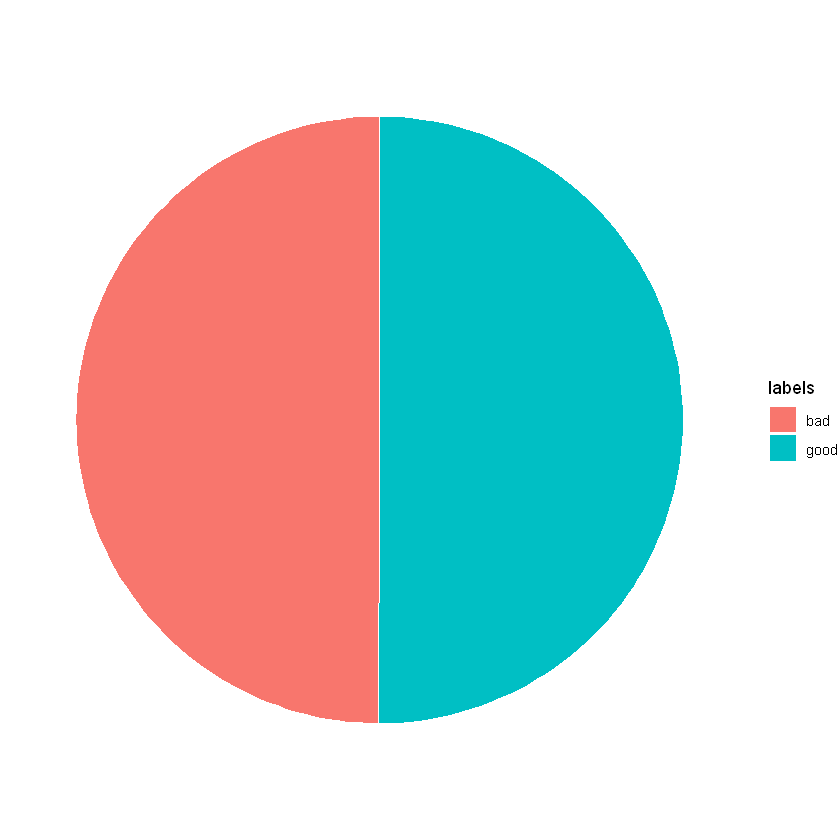

In [15]:
data_distribution_df <- data.frame(counts = c(sum(fdfp$label == "good"), sum(fdfp$label == "bad")),
                                   labels = c("good", "bad"))

ggplot(data_distribution_df, aes(x="", y=counts, fill=labels)) +
  geom_bar(stat="identity", width=1, color="white") +
  coord_polar("y", start=0) + 
  theme_void()

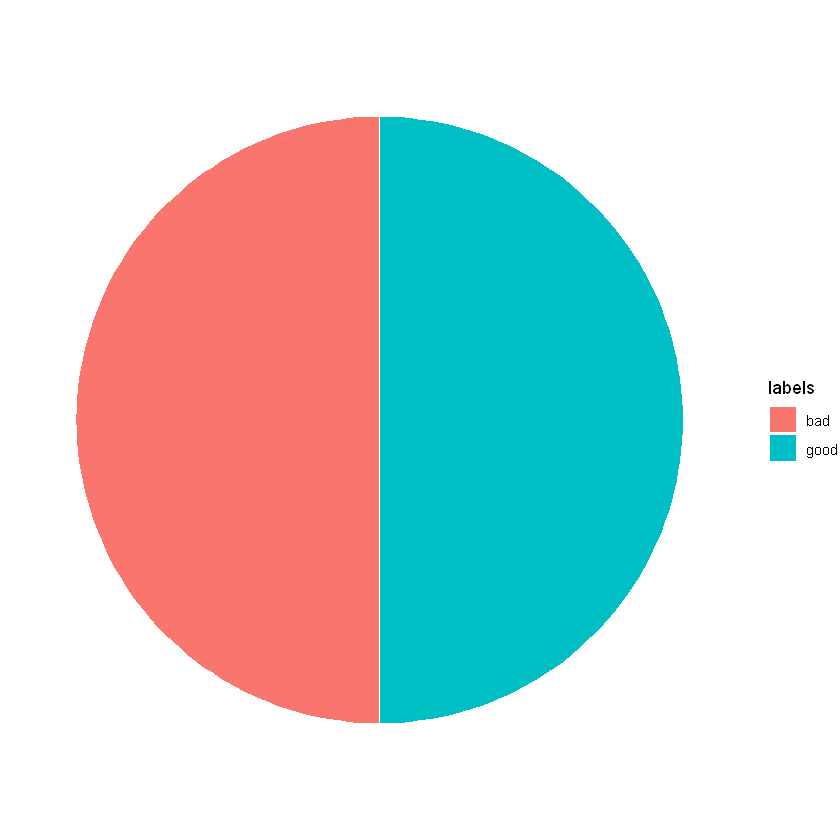

In [16]:
data_distribution_df2 <- data.frame(counts = c(sum(fdfm$label == "good"), sum(fdfm$label == "bad")),
                                   labels = c("good", "bad"))

ggplot(data_distribution_df2, aes(x="", y=counts, fill=labels)) +
  geom_bar(stat="identity", width=1, color="white") +
  coord_polar("y", start=0) + 
  theme_void()

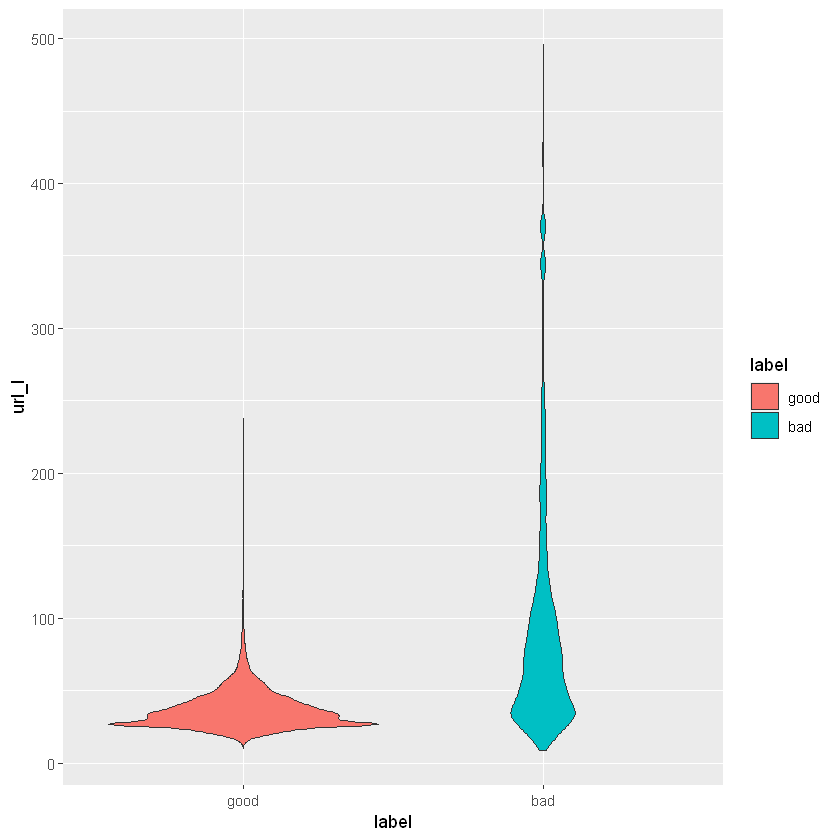

In [17]:
ggplot(fdfp[fdfp$url_l < 500, ], aes(x=label, y=url_l, fill=label)) + geom_violin()

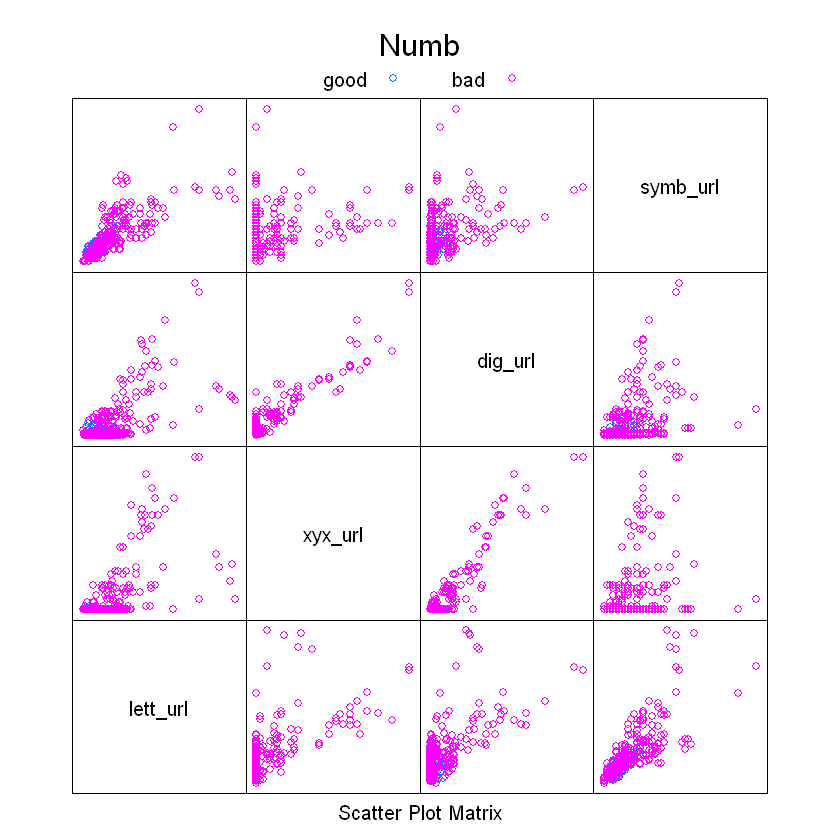

In [18]:
splom(~data.frame(lett_url, xyx_url, dig_url, symb_url), 
      data = fdfp[sample(nrow(fdfp), 500),],
      pch = 1,
      groups = label,
      pscales = 0,
      auto.key = list(columns = 2, title = "Numb")
      )

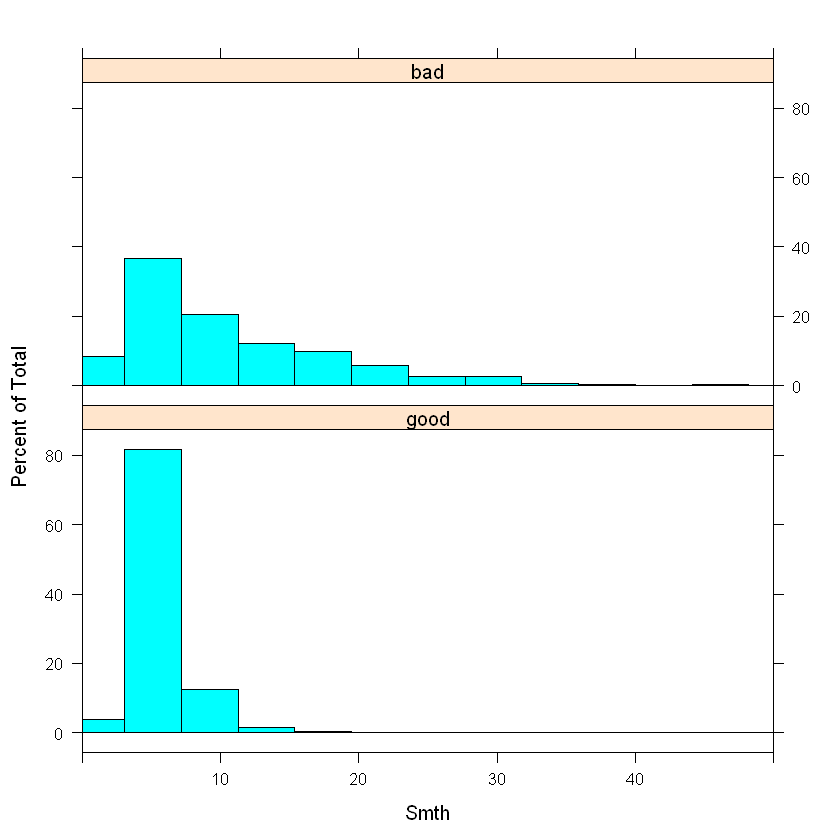

In [19]:
histogram(~ symb_url  | label  , 
          data = fdfp[sample(nrow(fdfp), 2000),],
          xlab = "Smth",
          layout = c(1, 2),
          nint = 20,
          xlim = c(0, 50)
         )

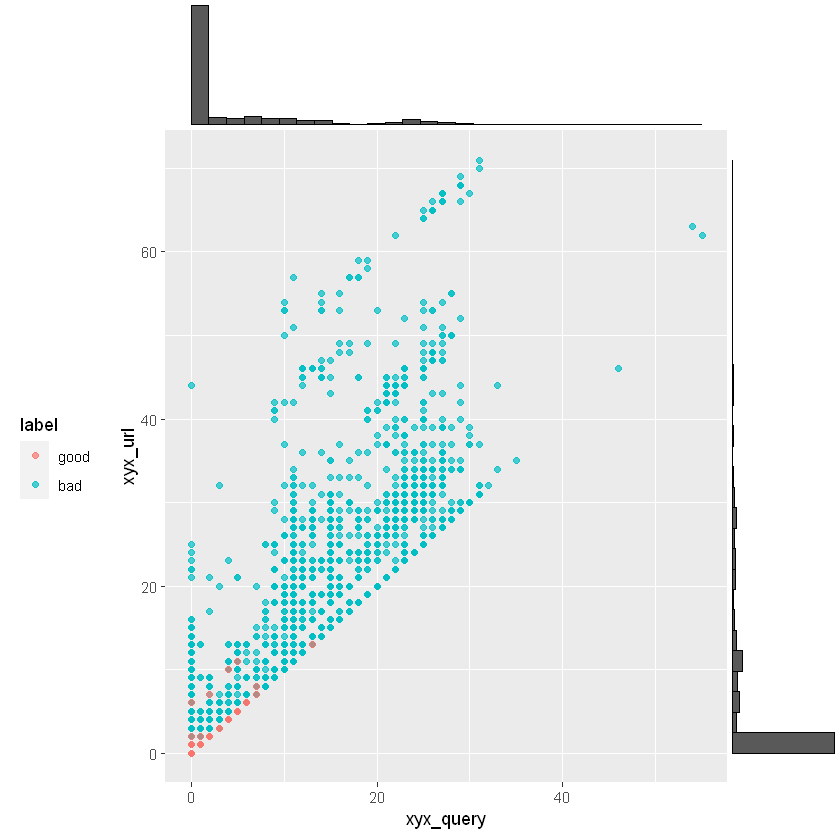

In [20]:
p <- ggplot(fdfp[fdfp$url_l < 1000, ], aes(x=xyx_query, y=xyx_url, color=label)) +
        geom_point(alpha=.7, na.rm=TRUE) + 
        theme(legend.position="left")
    
ggMarginal(p, type="histogram")

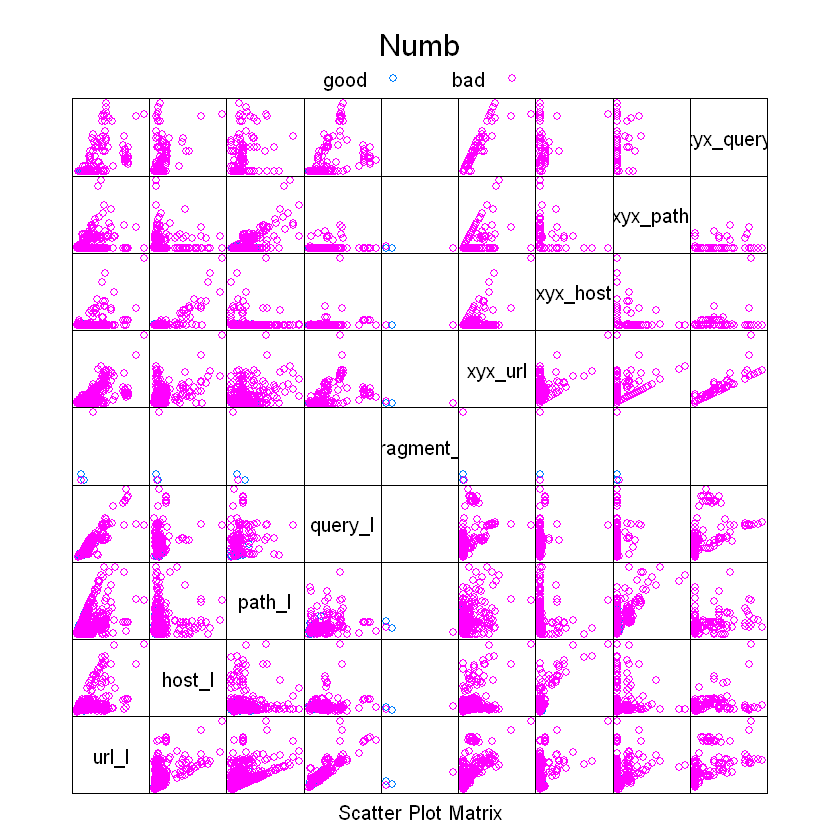

In [24]:
splom(~data.frame(url_l, host_l, path_l, query_l, fragment_l, xyx_url, xyx_host, xyx_path, xyx_query), 
      data = fdfp[sample(nrow(fdfp), 1000),],
      pch = 1,
      groups = label,
      pscales = 0,
      auto.key = list(columns = 2, title = "Numb")
      )

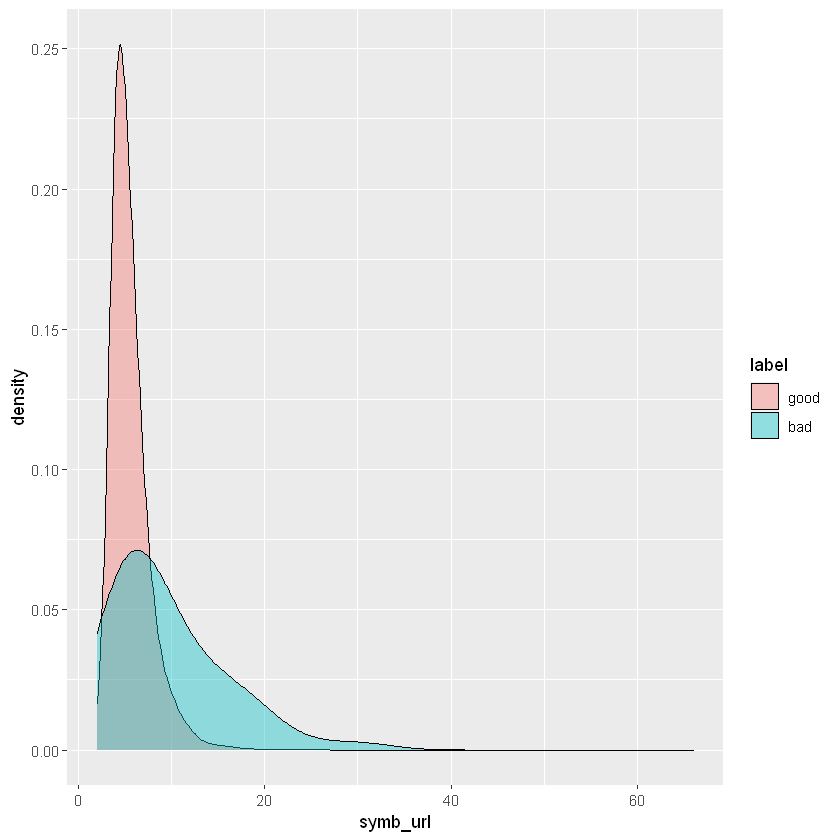

In [22]:
ggplot(data=fdfp[fdfp$url_l < 200, ], aes(x=symb_url, group=label, fill=label)) +
    geom_density(adjust=5, alpha=.4)

In [23]:
cat(c(colnames(fdfp), "\n\n\n", colnames(fdfm)), sep = ", ")

url, ranking, mld_res, mld.ps_res, label, url_l, host_l, path_l, query_l, fragment_l, host_by_url, path_by_url, query_by_url, path_by_host, query_by_host, query_by_path, ldl_url, ldl_host, ldl_path, ldl_query, ldl_fragment, dld_url, dld_host, dld_path, dld_query, dld_fragment, xyx_url, xyx_host, xyx_path, xyx_query, xyx_fragment, lett_url, lett_host, lett_path, lett_query, lett_fragment, dig_url, dig_host, dig_path, dig_query, dig_fragment, symb_url, symb_host, symb_path, symb_query, symb_fragment, 


, url, geo_loc, tld, who_is, https, js_len, js_obf_len, label, url_l, host_l, path_l, query_l, fragment_l, host_by_url, path_by_url, query_by_url, path_by_host, query_by_host, query_by_path, ldl_url, ldl_host, ldl_path, ldl_query, ldl_fragment, dld_url, dld_host, dld_path, dld_query, dld_fragment, xyx_url, xyx_host, xyx_path, xyx_query, xyx_fragment, lett_url, lett_host, lett_path, lett_query, lett_fragment, dig_url, dig_host, dig_path, dig_query, dig_fragment, symb_url, symb_host, symb_p